In [1]:
%load_ext autoreload

In [2]:
%autoreload
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import (
    DeepLift,
    FeatureAblation,
    GradientShap,
    IntegratedGradients,
    NoiseTunnel,
    Occlusion,
    GradientShap,
)
from spender.data.desi import DESI
from outlier_attribution.model import OutlierModel
from tqdm.auto import tqdm
from scipy.signal import savgol_filter

import random
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

from IPython import display

plt.style.use("js")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
random.seed(1)

In [5]:
trainloader = DESI.get_data_loader(
    "/scratch/gpfs/yanliang/desi-dynamic",
    which="train",
    batch_size=64,
    shuffle=True,
    shuffle_instance=True,
)

In [6]:
def get_baselines():
    s, _, _ = next(iter(trainloader))
    s = s.to(device).reshape(64, len(DESI._wave_obs))
    # z = z.to(device)
    return s

In [7]:
weight_dir = "/scratch/gpfs/js5013/programs/outlier-attribution/weights"
model = OutlierModel.from_weights(
    f"{weight_dir}/spender.desi-edr.galaxyae-b9bc8d12.pt",
    f"{weight_dir}/galaxy-flow-state_dict.pt",
).to(device)

In [8]:
with open("../data/DESI_EDR_top200_outliers.pkl", "rb") as f:
    data = pickle.load(f)

spectra = (
    torch.tensor(np.stack([data[i]["spectrum"] for i in range(1, 201)]))
    .to(device)
    .requires_grad_()
)
weights = (
    torch.tensor(np.stack([data[i]["weight"] for i in range(1, 201)]))
    .to(device)
    .requires_grad_()
)

In [9]:
selkeys = ["target_id", "z", "ra", "dec", "-logP"]
metadata = dict(
    zip(
        selkeys,
        (
            torch.tensor(np.stack([data[i][k] for i in range(1, 201)])).to(device)
            for k in selkeys
        ),
    )
)

# gets m star spectra

In [303]:
starloader = DESI.get_data_loader('/scratch/gpfs/yanliang/desi-dynamic/', tag='Star')

In [548]:
star_ids = np.array([39633402688703827, 39633402688703827, 39633162690625934, 39633118654631575,
39627878836472161, 39632991705629783, 39633158274026565,
39627740097282521, 39627915008150501, 39633127693353951,
39633453829851254, 39633290033891795, 39633552760899773])

In [550]:
specs = []
ids = []
zs = []

for (spec, weight, z, id, _, _) in tqdm(starloader):
    _, ix1, ix2 = np.intersect1d(np.asarray(id), star_ids, return_indices=True)
    if ix1.size > 0:
        print(ix1.size)
        specs.append(spec[ix1])
        ids.append(id[ix2])

  0%|          | 0/1 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1
1


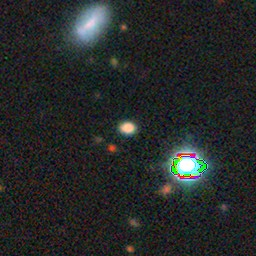

In [564]:
display.Image(DESI.get_image(target_id=39633149726034475, dir='/scratch/gpfs/js5013/data/desi/'))

In [320]:
star_spec = torch.stack(specs).squeeze(1).detach().cpu().numpy()

# define attribution methods

In [10]:
ig = IntegratedGradients(model)
fa = FeatureAblation(model)
oc = Occlusion(model)

In [683]:
def expected_gradients(spectrum, baselines, z):
    spectrum = spectrum.unsqueeze(0)
    attributions = []
    aligned_baselines = []
    for b in baselines:
        aligned_baseline = model.reconstruct(b, z).float() # put at same redshift first!!
        aligned_baselines.append(aligned_baseline)
        attributions.append(ig.attribute(spectrum, aligned_baseline.unsqueeze(0)))
    aligned_baselines = torch.stack(aligned_baselines)
    attributions = torch.stack(attributions).squeeze(1)
    baseline_weights = torch.softmax(torch.vmap(model)(baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
    # return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()
    return torch.mean(attributions, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()

In [12]:
def instantaneous_gradient(spectrum):
    mdl = lambda x: model(x.unsqueeze(0)).squeeze()
    attribution = torch.func.grad(mdl)(spectrum) * spectrum
    return attribution.detach().cpu().numpy()

In [689]:
def feature_ablation(spectrum, baseline):
    with torch.no_grad():
        assert spectrum.shape == baseline.shape
        assert spectrum.ndim == 1
        mask = torch.ones_like(spectrum, dtype=bool) # all like spectrum
        ref_output = model(spectrum.unsqueeze(0)).squeeze() # reference output to compare to
        grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array
        for i in tqdm(range(len(spectrum)), leave=False):
            mask[i] = False # replace spectral element with baseline
            new[:] = torch.where(mask, spectrum, baseline)
            new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
            grad[i] = ref_output - new_output # save difference
            mask[i] = True # put spectra element back
        return grad

def random_ablation(spectrum, baselines, z, mask_frac=0.05, iterations=10):
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in baselines:
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)

        ref_output = model(spectrum.unsqueeze(0)).squeeze() # reference output to compare to
        
        grad = torch.zeros((len(baselines), len(spectrum)), dtype=spectrum.dtype).to(spectrum.device) # store grads
        temp_grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array
        counts = torch.zeros_like(spectrum, dtype=spectrum.dtype)
        for i, b in tqdm(enumerate(aligned_baselines), total=len(baselines)):
            temp_grad[:] = 0.
            counts[:] = 0.
            for _ in range(iterations):
                mask = torch.tensor(np.random.choice(2, size=len(spectrum), replace=True, p=[mask_frac, 1-mask_frac]), dtype=bool).to(spectrum.device) # replace 10% with baseline
                new[:] = torch.where(mask, spectrum, b) # 90% spectrum, 10% baseline
                new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
                temp_grad[~mask] += ref_output - new_output # accumulate difference in all masked pixels
                counts[~mask] += 1.
            div_mask = torch.where(counts > 0.)
            # print((counts > 0.).sum())
            grad[i][div_mask] = (temp_grad / counts)[div_mask]

        # return torch.sum(grad * baseline_weights, dim=0).detach().cpu().numpy()
        return torch.mean(grad, dim=0).detach().cpu().numpy()

def expected_ablation(spectrum, baselines, z):
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in baselines:
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        # baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
        for b in tqdm(aligned_baselines):
            attributions.append(feature_ablation(spectrum, b))
        attributions = torch.stack(attributions)
        # return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()
        return torch.mean(attributions, dim=0).detach().cpu().numpy(), aligned_baselines.detach().cpu().numpy()


def no_overlap_occlusion(spectrum, baseline, window_size, offset):
    with torch.no_grad():
        assert spectrum.shape == baseline.shape
        assert spectrum.ndim == 1
        
        ref_output = model(baseline.unsqueeze(0)).squeeze() # reference output to compare to
        grad = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store grads
        new = torch.zeros_like(spectrum, dtype=spectrum.dtype) # store new array

        n_shifts = []
        offset = offset % window_size
        stride = window_size
        npix = len(spectrum)
        chunks = int(np.ceil(len(spectrum[offset:]) / window_size))
        if offset > 0:
            chunks += 1

        ctr = 0
        mask = torch.ones_like(spectrum, dtype=bool) # all like spectrum
        
        for i in range(chunks):
            if offset > 0:
                if i == 0: # check for offset in first block
                    mask[:offset] = False # just mask the first few elements for first chunk
                else:
                    mask[ctr : ctr + window_size] = False
            else:
                mask[ctr : ctr + window_size] = False # do things normally, mask whole window

            new[:] = torch.where(mask, baseline, spectrum)#, baseline)
            new_output = model(new.unsqueeze(0)).squeeze() # calculate new output
            grad[ctr : ctr + window_size] = (ref_output - new_output) / (~mask).sum() # save difference in all masked pixels

            # put spectral elements back
            if offset > 0:
                if i == 0: # check for offset in first block
                    mask[:offset] = True # just mask the first few elements for first chunk
                    ctr += offset
                else:
                    mask[ctr : ctr + window_size] = True
                    ctr += stride
            else:
                mask[ctr : ctr + window_size] = True
                ctr += stride # move over by stride
        
        return grad


def multiscale_occlusion(spectrum, baselines, z, window_sizes=[8, 16, 32, 64, 128, 256], offsets=[0, 0, 0, 0, 0, 0], avg_over_baselines=True):
    assert len(window_sizes) == len(offsets)
    with torch.no_grad():
        attributions = []
        aligned_baselines = []
        for b in baselines:
            aligned_baselines.append(model.reconstruct(b, z))
        aligned_baselines = torch.stack(aligned_baselines).float()
        # baseline_weights = torch.softmax(torch.vmap(model)(aligned_baselines.unsqueeze(1)).squeeze(1), dim=0).unsqueeze(1)
        for ws, os in tqdm(zip(window_sizes, offsets), total=len(window_sizes)):
            if avg_over_baselines:
                attributions.append(torch.mean(torch.stack([no_overlap_occlusion(spectrum, b, ws, os) for b in aligned_baselines]), dim=0))
            else:
                attributions.append(torch.stack([no_overlap_occlusion(spectrum, b, ws, os) for b in aligned_baselines]))

        stacked_attributions = torch.stack(attributions).detach().cpu().numpy()
        attribution_stds = stacked_attributions.std(axis=1)
        return stacked_attributions, aligned_baselines.detach().cpu().numpy(), attribution_stds
        
        # for b in tqdm(aligned_baselines):
        #     attributions.append(torch.mean(torch.stack([no_overlap_occlusion(spectrum, b, ws, os) for ws, os in zip(window_sizes, offsets)]), dim=0))
        #     # attributions.append(torch.mean(torch.stack([oc.attribute(spectrum.unsqueeze(0), sliding_window_shapes=(bs,), strides=(bs,), baselines=b.unsqueeze(0)) for bs in scales]), dim=0))
        # attributions = torch.stack(attributions).squeeze(1)
        # return torch.sum(attributions * baseline_weights, dim=0).detach().cpu().numpy(), aligned_baselines

In [690]:
attribution_labels = [
    "Grad",
    "IG (0 BL)",
    "EG",
    "FA (0 BL)",
    "IMO",
]

In [691]:
ix = 3

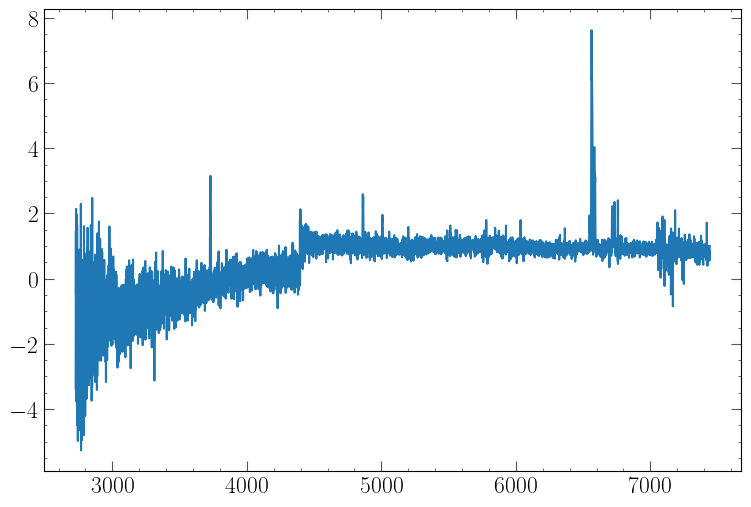

In [692]:
xwave = DESI._wave_obs / (1 + metadata['z'][ix].item())

plt.plot(xwave, spectra[ix].detach().cpu())
# plt.plot(star_spec[2], c='gray', alpha=0.6, lw=0.4)
# [plt.plot(xwave, abl[i], c='gray', alpha=0.3) for i in range(8)]
# plt.xlim(6550, 6600)
# plt.xlim(3700, 3750)
# plt.axvline(6564.61)
# plt.axvline(6567)
# plt.axvline(6561)
# plt.ylim(-1.5, 4)
# plt.axvline(6583)
# plt.axvline(6585.27)
# plt.plot(xwave, model.reconstruct(spectra[ix], metadata['z'][ix]).detach().cpu())

In [693]:
bl = get_baselines()
inst_attr = instantaneous_gradient(spectra[ix])
ig_attr = ig.attribute(spectra[ix].unsqueeze(0))
eg_attr = expected_gradients(spectra[ix], bl[:64], metadata['z'][ix])
# efa_attr = expected_ablation(spectra[ix], bl[:1], metadata['z'][ix])
fa_attr = fa.attribute(spectra[ix].unsqueeze(0))
mso_attr, abl, imow = multiscale_occlusion(spectra[ix], bl[:8], metadata['z'][ix], window_sizes=[ 2**(2*k) for k in range(0,5)], offsets=list(np.cumsum([0,] + [ 2**(2*k-1) for k in range(1,5) ])), avg_over_baselines=False)
# ra_attr = random_ablation(spectra[ix], bl, metadata['z'][ix], mask_frac=0.2, iterations=50)

/scratch/gpfs/js5013/miniconda3/envs/outlier_attribution/lib/python3.10/site-packages/torch/nn/functional.py:696: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::max_pool1d. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/5 [00:00<?, ?it/s]

In [730]:
imo = ((mso_attr.mean(axis=1) * (1/imow)).sum(axis=0) / (1/imow).sum(axis=0))

In [731]:
attributions = np.stack([inst_attr, ig_attr[0].detach().cpu().numpy(), eg_attr[0], fa_attr[0].detach().cpu().numpy(), imo])

In [758]:
# nb = '#81A1C1'
nb = 'k'
ng = 'gray'
no = '#455f80'
nr = '#BF616A'
nv = '#D08770'

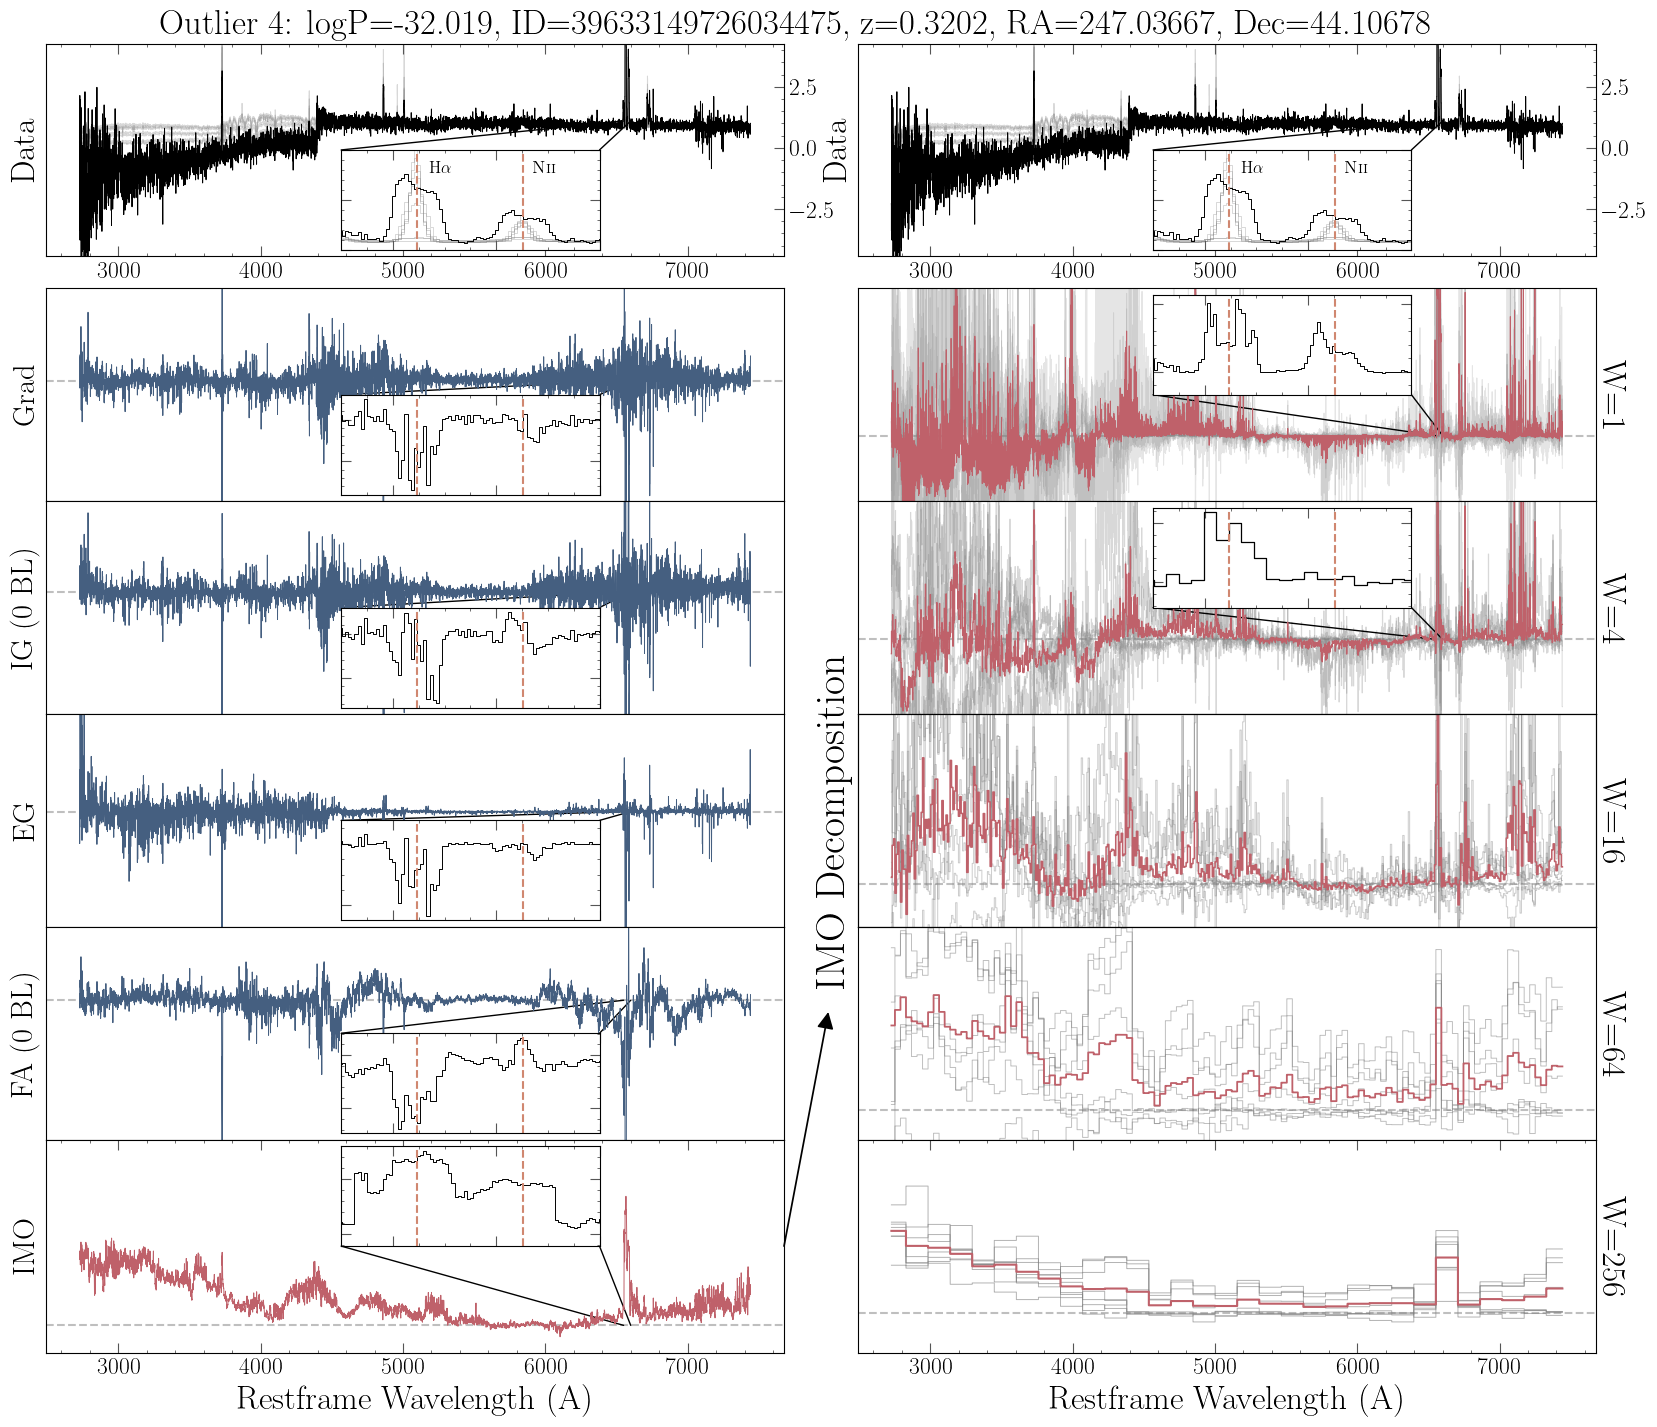

In [952]:
nattr = len(attributions)

fig = plt.figure(figsize=(20, 17))
gs_outer = gridspec.GridSpec(2, 1, figure=fig, hspace=0.05, height_ratios=[1, 5])

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs_outer[0], width_ratios=[1, 1], wspace=0.1)
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs_outer[1], width_ratios=[1, 1], wspace=0.1)
gs_left = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec = gs_bottom[0], hspace=0.0)
gs_right = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec = gs_bottom[1], hspace=0.0)

ax_top = [fig.add_subplot(gs_top[:,i]) for i in range(2)]
ax_left = [fig.add_subplot(gs_left[i]) for i in range(5)]
ax_right = [fig.add_subplot(gs_right[i]) for i in range(5)]


plt.suptitle(
    f"Outlier {ix + 1}: logP={-metadata['-logP'][ix]:.3f}, ID={metadata['target_id'][ix]}, z={metadata['z'][ix]:.4f}, RA={metadata['ra'][ix]:.5f}, Dec={metadata['dec'][ix]:.5f}",
    fontsize=25,
    y=0.9
)

for axt in ax_top:
    [axt.step(xwave, b, c=ng, zorder=-5, alpha=0.3, lw=0.7, rasterized=True) for b in abl]
    axt.step(xwave, spectra[ix].detach().cpu(), c=nb, lw=0.7)
    axt.yaxis.tick_right()
    axt.set_ylabel("Data")
    axt.set_ylim(np.quantile(spectra[ix].detach().cpu().numpy(), [0.005, 0.995]) * np.array([1.5, 1.5]) + np.array([-0.15, 0.5]))


for j in range(nattr):
    ax_left[j].plot(
        xwave,
        attributions[j],# * np.sqrt(weights[ix].detach().cpu().numpy()),
        label=attribution_labels[j], c=no if j + 1 < nattr else nr, lw=0.7
    )
    ax_left[j].set_ylim(*np.quantile(attributions[j], [0.005, 0.995]) * np.array([1.5, 2]) + np.array([-0.25, 0.25]) * (1 if j + 1 < nattr else 0.1))
    ax_left[j].axhline(0, c=ng, alpha=0.5, ls="--", zorder=-5)
    ax_left[j].set_ylabel(attribution_labels[j], fontsize=22)
    ax_left[j].set_yticks([])
    # ax[j + 1].set_ylim(*torch.quantile(attributions[0], torch.tensor([0.01, 0.99]).double().to(device)).detach().cpu().numpy())
    # ax[j + 1].set_xlim(8600, 8800)
    if j + 1 < nattr:
        ax_left[j].xaxis.set_visible(False)
    else:
        ax_left[j].set_xlabel("Restframe Wavelength (A)")
    # ax_left[j].set_xlim(6500, 6650)

for j in range(nscales):
    ax_right[j].step(xwave, mso_attr[j].T, c=ng, alpha=0.2 + 0.1 * j, zorder=-5, lw=0.7, rasterized=True)
    ax_right[j].step(xwave, mso_attr[j].mean(axis=0), c=nr, lw=0.7 + 0.2 * j)
    ax_right[j].axhline(0, c="gray", alpha=0.5, ls="--", zorder=-5)
    ax_right[j].set_ylabel(f"W={[ 2**(2*k) for k in range(0, 5)][j]}", rotation=270, labelpad=22)
    ax_right[j].set_yticks([])
    ax_right[j].yaxis.set_label_position("right")
    if j + 1 < nattr:
        ax_right[j].xaxis.set_visible(False)
    else:
        ax_right[j].set_xlabel("Restframe Wavelength (A)")
    # ax_right[j].plot(DESI._wave_obs, (star_spec[2]) / star_spec[2].std() * np.einsum('bp,bd -> p', mso_attr[j], blw).std() * 1.2, c='#A3BE8C', zorder=5, lw=0.3)
    # ax_right[j].set_xlim(6500, 6650)
    ax_right[j].set_ylim(*np.quantile(mso_attr[j].mean(axis=0), [0.005, 0.995]) + np.array([-0.05, 0.1]))

ax_label = ax_right[2].twinx()
ax_label.yaxis.set_label_position('left')
ax_label.set_yticks([])
ax_label.set_ylabel('IMO Decomposition', fontsize=30)

# arrow
con = ConnectionPatch(xyA=(1,0.5), xyB=(-0.04,0.6), coordsA='axes fraction', coordsB='axes fraction', 
                      axesA=ax_left[-1], axesB=ax_right[-2], color="k", arrowstyle='-|>', clip_on=False, mutation_scale=25, linewidth=1.25)
ax_left[-1].add_artist(con)

# insets

for axt in ax_top:
    axins = axt.inset_axes([0.4, 0.03, 0.35, 0.47])
    axins.step(xwave, spectra[ix].detach().cpu(), c=nb, lw=0.7)
    [axins.step(xwave, b, c=ng, zorder=-5, alpha=0.3, lw=0.7) for b in abl]
    # sub region of the original image
    # x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
    axins.set_xlim(6550, 6600)
    axins.set_ylim(0, 10)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    con1 = ConnectionPatch(xyA=(0, 1), xyB=(6550,1.1), coordsA='axes fraction', coordsB='data', 
                          axesA=axins, axesB=axt, color="k", clip_on=False, mutation_scale=2)
    con2 = ConnectionPatch(xyA=(1, 1), xyB=(6600,1.1), coordsA='axes fraction', coordsB='data', 
                          axesA=axins, axesB=axt, color="k", clip_on=False, mutation_scale=2)
    axt.add_artist(con1)
    axt.add_artist(con2)
    axins.axvline(6564.61, c=nv, ls='--')
    axins.axvline(6585.27, c=nv, ls='--')
    axins.annotate(r'H$\alpha$', xy=(0.34, 0.77), xycoords='axes fraction', fontsize=12)
    axins.annotate(r'$\textsc{Nii}$', xy=(0.74, 0.77), xycoords='axes fraction', fontsize=12)


for i in range(4):
    
    axins = ax_left[i].inset_axes([0.4, 0.03, 0.35, 0.47])
    axins.step(xwave, attributions[i], c=nb, lw=0.7)
    # sub region of the original image
    axins.set_xlim(6550, 6600)
    # axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    con1 = ConnectionPatch(xyA=(0, 1), xyB=(6550,0), coordsA='axes fraction', coordsB='data', 
                          axesA=axins, axesB=ax_left[i], color="k", clip_on=False, mutation_scale=2)
    con2 = ConnectionPatch(xyA=(1, 1), xyB=(6600,0), coordsA='axes fraction', coordsB='data', 
                          axesA=axins, axesB=ax_left[i], color="k", clip_on=False, mutation_scale=2)
    ax_left[i].add_artist(con1)
    ax_left[i].add_artist(con2)
    axins.axvline(6564.61, c=nv, ls='--')
    axins.axvline(6585.27, c=nv, ls='--')


axins = ax_left[-1].inset_axes([0.4, 0.5, 0.35, 0.47])
axins.step(xwave, attributions[-1], c=nb, lw=0.7)
axins.set_xlim(6550, 6600)
# axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
con1 = ConnectionPatch(xyA=(0, 0), xyB=(6550,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_left[-1], color="k", clip_on=False, mutation_scale=2)
con2 = ConnectionPatch(xyA=(1, 0), xyB=(6600,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_left[-1], color="k", clip_on=False, mutation_scale=2)
ax_left[-1].add_artist(con1)
ax_left[-1].add_artist(con2)
axins.axvline(6564.61, c=nv, ls='--')
axins.axvline(6585.27, c=nv, ls='--')


axins = ax_right[0].inset_axes([0.4, 0.5, 0.35, 0.47])
axins.step(xwave, mso_attr[0].mean(axis=0), c=nb, lw=0.7 + 0.2 * 0)
axins.set_xlim(6550, 6600)
# axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
con1 = ConnectionPatch(xyA=(0, 0), xyB=(6550,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_right[0], color="k", clip_on=False, mutation_scale=2)
con2 = ConnectionPatch(xyA=(1, 0), xyB=(6600,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_right[0], color="k", clip_on=False, mutation_scale=2)
ax_right[0].add_artist(con1)
ax_right[0].add_artist(con2)
axins.axvline(6564.61, c=nv, ls='--')
axins.axvline(6585.27, c=nv, ls='--')


axins = ax_right[1].inset_axes([0.4, 0.5, 0.35, 0.47])
axins.step(xwave, mso_attr[1].mean(axis=0), c=nb, lw=0.7 + 0.2 * 1)
axins.set_xlim(6550, 6600)
# axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
con1 = ConnectionPatch(xyA=(0, 0), xyB=(6550,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_right[1], color="k", clip_on=False, mutation_scale=2)
con2 = ConnectionPatch(xyA=(1, 0), xyB=(6600,0), coordsA='axes fraction', coordsB='data', 
                      axesA=axins, axesB=ax_right[1], color="k", clip_on=False, mutation_scale=2)
ax_right[1].add_artist(con1)
ax_right[1].add_artist(con2)
axins.axvline(6564.61, c=nv, ls='--')
axins.axvline(6585.27, c=nv, ls='--')

fig.savefig('attribution-4-insets.pdf', dpi=300, bbox_inches='tight')

#### make diagram showing inverse occlusion

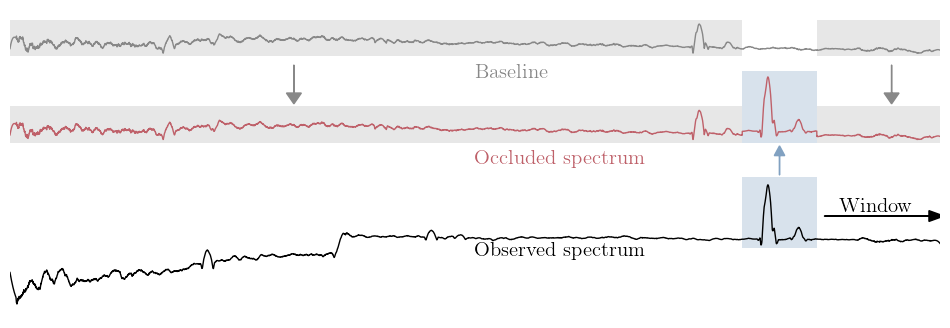

In [948]:
plt.figure(figsize=(12, 4))

ax = plt.gca()

blue = '#81A1C1'
gray = '#888'

ibl = savgol_filter(bl[3].detach().cpu(), 101, 3)
isp = savgol_filter(spectra[ix].detach().cpu(), 101, 3)
irp = np.where(((DESI._wave_obs > 8500) & (DESI._wave_obs < 9000)).numpy(), isp, ibl)

ax.plot(DESI._wave_obs, ibl , c=gray, lw=1)
ax.plot(DESI._wave_obs, isp - 9 , c='k', lw=1, zorder=-2)
ax.plot(DESI._wave_obs, irp - 4, c=nr, lw=1)

# ax.yaxis.set_ticks([])

ax.annotate('Baseline', xy=(0.5, 0.78), xycoords='axes fraction', c=gray, fontsize=15)
ax.annotate('Occluded spectrum', xy=(0.5, 0.5), xycoords='axes fraction', c=nr, fontsize=15)
ax.annotate('Observed spectrum', xy=(0.5, 0.2), xycoords='axes fraction', c='k', fontsize=15)


box1 = Rectangle((3550, 0.4), 4950, 1.7, edgecolor='none', facecolor=gray, alpha=0.2)
box2 = Rectangle((8500, -8.5), 500, 3.3, edgecolor='none', facecolor=blue, alpha=0.3, zorder=-5)
box3 = Rectangle((9000, 0.4), 850, 1.7, edgecolor='none', facecolor=gray, alpha=0.2)

box1m = Rectangle((3550, -3.6), 4950, 1.7, edgecolor='none', facecolor=gray, alpha=0.2)
box2m = Rectangle((8500, -3.6), 500, 3.3, edgecolor='none', facecolor=blue, alpha=0.3, zorder=-5)
box3m = Rectangle((9000, -3.6), 850, 1.7, edgecolor='none', facecolor=gray, alpha=0.2)

ax.add_artist(box1)
ax.add_artist(box2)
ax.add_artist(box3)

ax.add_artist(box1m)
ax.add_artist(box2m)
ax.add_artist(box3m)

ax.arrow(5500, 0, 0, -1.3, head_width=100, head_length=0.5, fc=gray, ec=gray)
ax.arrow(9500, 0, 0, -1.3, head_width=100, head_length=0.5, fc=gray, ec=gray)
ax.arrow(8750, -5.1, 0, 0.9, head_width=70, head_length=0.45, fc=blue, ec=blue)

# ax.arrow(7600, -7, 700, 0, head_width=0.5, head_length=100, fc='k', ec='k')
ax.arrow(9050, -7, 700, 0, head_width=0.5, head_length=100, fc='k', ec='k')

# ax.annotate('Sliding', xy=(7750, -6.8), xycoords='data', fontsize=15)
ax.annotate('Window', xy=(9150, -6.8), xycoords='data', fontsize=15)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

plt.xlim(DESI._wave_obs[0], DESI._wave_obs[-1])

ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)

plt.savefig('inverse-occlusion-nospine.pdf', dpi=300, bbox_inches='tight')
